In [1]:
# import libraries 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
""" Raw experimental images"""

filepath_exp= '/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed'
filename_exp= 'Fixed_29_2.TIF'


"""" Simulation image for the corresponding experimental image """

# Define the folder where the images are stored
filepath_sim = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'  # Replace with your folder path
filename_sim='Fixed_29_2.TIF'


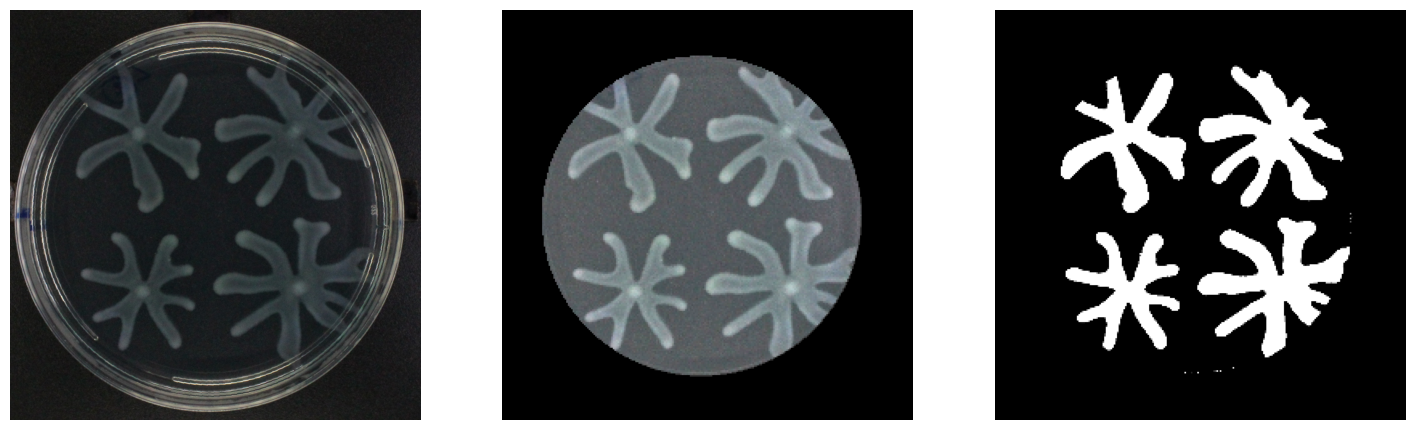

In [24]:
"""Masking, brightness and contast adjustment, also binary thresholding for structure testing """
rfactor=256
img_length=rfactor
img_width=rfactor

img = cv2.imread(os.path.join(filepath_exp,filename_exp))
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find edges in the image using Canny edge detection
edges = cv2.Canny(img_gray, 100, 200)

# Find circles in the image using HoughCircles method
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=20, maxRadius=600)

# print(circles)

# Assuming the first detected circle is the plate (adjust accordingly)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x_center, y_center, radius) in circles:
        # Define a new radius for the mask that is 20 pixels smaller than the detected radius
        new_radius = radius -82
        # print(new_radius)

        # Create a mask where all values are set to zero (black)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

        # Draw a filled white circle on the mask where the new, smaller circle is
        cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

        # Apply the mask to the original image (set pixels outside the new circle to black)
        img_masked = cv2.bitwise_and(img, img, mask=mask)


        # Adjust contrast and brightness
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 50    # Brightness control (0-100)
        adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)



        # non thresholded images
        # Convert BGR images to RGB for plotting with matplotlib
        img_masked_rgb = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB)
        # img_masked_resized=cv2.resize(img_masked_rgb,(img_length,img_width))

        
        # resize both the adjusted image and the mask
        img_resized = cv2.resize(img_masked_rgb, (img_length, img_width))
        mask_resized = cv2.resize(mask,(img_length, img_width),interpolation=cv2.INTER_NEAREST)

        # re-mask the resized image to force a black border outside the circle
        img_masked_resized = cv2.bitwise_and(img_resized,img_resized,mask=mask_resized)
    


        # Thresholding images

        # Convert to grayscale and apply thresholding
        img_gray_adj = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(img_gray_adj, (5, 5), 0)
        _, img_thresh = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY)

        # Crop and resize the image
        # new_height = img_thresh.shape[0] - (top_crop + bottom_crop)
        # new_width = img_thresh.shape[1] - (left_crop + right_crop)
        # img_cropped = img_thresh[top_crop:top_crop + new_height, left_crop:left_crop + new_width]
        img_resized = cv2.resize(img_thresh, (img_length, img_width))

        plt.figure(figsize=(18, 6))
        # Plot the original image
        plt.subplot(1,3,1)
        plt.imshow(img_rgb)
        plt.axis("off")

        # Plot the masked original image
        
        plt.subplot(1, 3, 2)
        plt.imshow(img_masked_resized,cmap='gray')
        # turn axis off
        plt.axis('off')
        # plt.title('Image after contast and brightness adjustment')

        # Plot the image after rotation within the masked circle
        plt.subplot(1, 3, 3)
        plt.imshow(img_resized,cmap='gray')
        # plt.title('Thresholded image')
        plt.axis('off')
  

        
        plt.show()

        break
else:
    print("No circles were found")


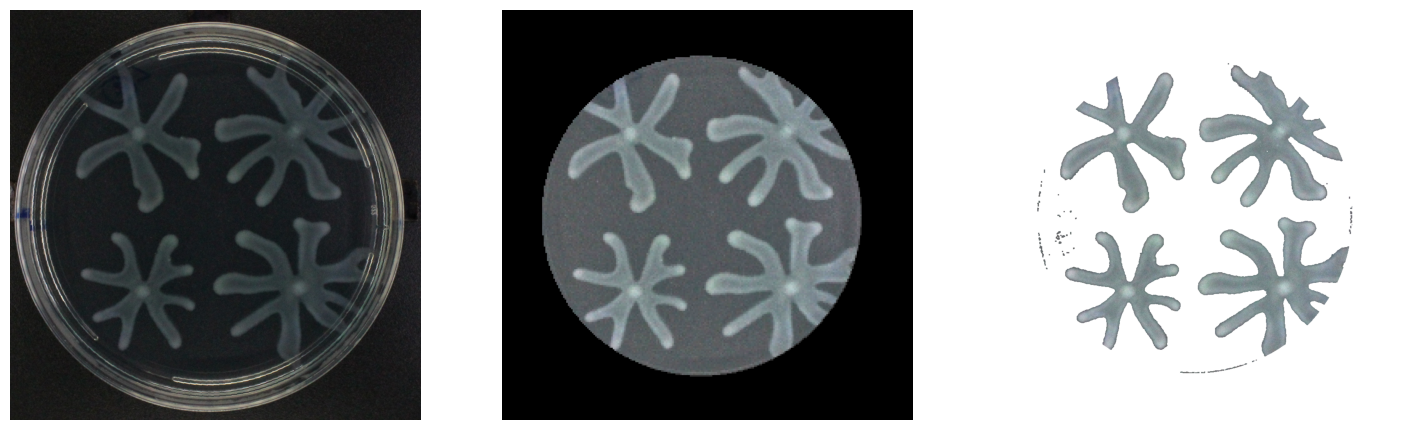

In [ ]:
"""Masking, brightness and contast adjustment, plus trying image segmentation (NOT in current version of paper) """

def reveal_colonies_white_bg(p):
    im = p
    g  = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # plate mask
    circ = cv2.HoughCircles(g, cv2.HOUGH_GRADIENT, 1, 200, param1=100, param2=30, minRadius=80)
    plate = np.zeros_like(g)
    if circ is not None:
        x, y, r = np.int32(circ[0, 0]); cv2.circle(plate, (x, y), r-3, 255, -1)
    else:
        plate[:] = 255

    # boost + threshold (colonies are brighter)
    g2 = cv2.createCLAHE(2.0, (8,8)).apply(g)
    g2 = cv2.GaussianBlur(g2, (5,5), 0)
    _, col = cv2.threshold(g2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    col = cv2.morphologyEx(col, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), 1)

    mask = cv2.bitwise_and(col, plate)             # only inside plate

    # white background, keep colony intensities
    out = np.full_like(im, 255)
    out[mask == 255] = im[mask == 255]

    mask3 = (mask == 255)[..., None]           # HxWx1
    out   = np.where(mask3, im, 255)           # keep color, white elsewhere
    out   = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)  # return RGB
    return out




rfactor=256
img_length=rfactor
img_width=rfactor

img = cv2.imread(os.path.join(filepath_exp,filename_exp))
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find edges in the image using Canny edge detection
edges = cv2.Canny(img_gray, 100, 200)

# Find circles in the image using HoughCircles method
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=20, maxRadius=600)

# print(circles)

# Assuming the first detected circle is the plate (adjust accordingly)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x_center, y_center, radius) in circles:
        # Define a new radius for the mask that is 20 pixels smaller than the detected radius
        new_radius = radius -82
        # print(new_radius)

        # Create a mask where all values are set to zero (black)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

        # Draw a filled white circle on the mask where the new, smaller circle is
        cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

        # Apply the mask to the original image (set pixels outside the new circle to black)
        img_masked = cv2.bitwise_and(img, img, mask=mask)


        # Adjust contrast and brightness
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 50    # Brightness control (0-100)
        adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)



        # non thresholded images
        # Convert BGR images to RGB for plotting with matplotlib
        img_masked_rgb = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB)
        # img_masked_resized=cv2.resize(img_masked_rgb,(img_length,img_width))

        
        # resize both the adjusted image and the mask
        img_resized = cv2.resize(img_masked_rgb, (img_length, img_width))
        mask_resized = cv2.resize(mask,(img_length, img_width),interpolation=cv2.INTER_NEAREST)

        # re-mask the resized image to force a black border outside the circle
        img_masked_resized = cv2.bitwise_and(img_resized,img_resized,mask=mask_resized)
    


        # Thresholding images

        #  Convert background to white 

        # img_gray_adj_bgwhite = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
        
        # doing some image segmentaion to convert background to white

        # convert to hsv 
        img_hsv = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2HSV)
        # define range of dark colors in HSV
        lower_dark = np.array([0, 0, 0])
        upper_dark = np.array([209,7, 80])  # adjust the

        # create a mask for dark colors
        mask_dark = cv2.inRange(img_hsv, lower_dark, upper_dark)    
        # invert the mask to get the non-dark areas
        mask_non_dark = cv2.bitwise_not(mask_dark)
        # convert the non-dark areas to white in the original image
        img_bgwhite = adjusted_image.copy()
        img_bgwhite[mask_dark == 255] = [255, 255, 255]

        # convert to rgb for display
        img_bgwhite_rgb = cv2.cvtColor(img_bgwhite, cv2.COLOR_BGR2RGB)


        img_segmented=reveal_colonies_white_bg(adjusted_image)
        
        # # Convert to grayscale and apply thresholding
        # img_gray_adj = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
        # blur = cv2.GaussianBlur(img_gray_adj, (5, 5), 0)
        # _, img_thresh = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY)

        # Crop and resize the image
        # new_height = img_thresh.shape[0] - (top_crop + bottom_crop)
        # new_width = img_thresh.shape[1] - (left_crop + right_crop)
        # img_cropped = img_thresh[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        # img_resized = cv2.resize(img_thresh, (img_length, img_width))

        plt.figure(figsize=(18, 6))
        # Plot the original image
        plt.subplot(1,3,1)
        plt.imshow(img_rgb)
        plt.axis("off")

        # Plot the masked original image
        
        plt.subplot(1, 3, 2)
        plt.imshow(img_masked_resized,cmap='gray')
        # turn axis off
        plt.axis('off')
        # plt.title('Image after contast and brightness adjustment')

        # Plot the image after rotation within the masked circle
        plt.subplot(1, 3, 3)
        plt.imshow(img_segmented)
        # plt.title('Thresholded image')
        plt.axis('off')
  

        
        plt.show()

        break
else:
    print("No circles were found")


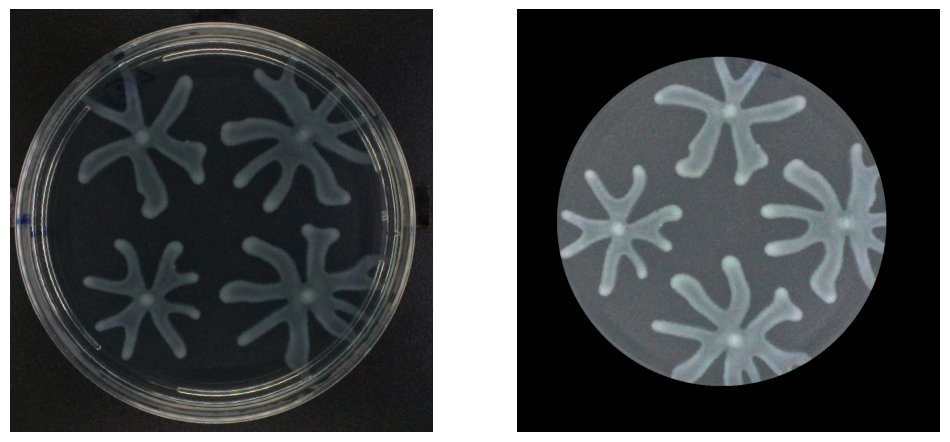

In [25]:
"""Rotation augmentation example, in total experiments include rotations per 3.6 degrees i.e 100 rotations per image """

img = cv2.imread(os.path.join(filepath_exp,filename_exp))
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find edges in the image using Canny edge detection
edges = cv2.Canny(img_gray, 100, 200)

# Find circles in the image using HoughCircles method
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=20, maxRadius=600)

# print(circles)

# Assuming the first detected circle is the plate (adjust accordingly)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x_center, y_center, radius) in circles:
        # Define a new radius for the mask that is 20 pixels smaller than the detected radius
        new_radius = radius -82
        # print(new_radius)

        # Create a mask where all values are set to zero (black)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

        # Draw a filled white circle on the mask where the new, smaller circle is
        cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

        # Apply the mask to the original image (set pixels outside the new circle to black)
        img_masked = cv2.bitwise_and(img, img, mask=mask)


        # Adjust contrast and brightness
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 50    # Brightness control (0-100)
        adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

        # Specify the rotation angle theta in degrees
        theta = 45 #45
        theta_rad = np.deg2rad(theta)

        # Create an output image (initially black or any background color you prefer)
        output_img = np.zeros_like(img)

        # Iterate over each pixel in the output image
        for x_prime in range(img.shape[1]):
            for y_prime in range(img.shape[0]):
                # Apply the inverse rotation transformation (backward mapping)
                x = np.cos(theta_rad) * (x_prime - x_center) + np.sin(theta_rad) * (y_prime - y_center) + x_center
                y = -np.sin(theta_rad) * (x_prime - x_center) + np.cos(theta_rad) * (y_prime - y_center) + y_center

                # Check if the source pixel (x, y) is within the new circle's boundaries
                if (x - x_center)**2 + (y - y_center)**2 <= new_radius**2:
                    # Check if it's inside the image
                    if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                        # Sample the pixel from the masked image to the output image
                        output_img[y_prime, x_prime] = adjusted_image[int(y), int(x)]

        # Convert BGR images to RGB for plotting with matplotlib
        img_masked_rgb = cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB)
        output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

        # Plot the masked original image
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        # plt.title('Masked Original Image')
        plt.axis("off")

        # Plot the image after rotation within the masked circle
        plt.subplot(1, 2, 2)
        plt.imshow(output_img_rgb)
        plt.axis("off")
        # plt.title('Image after rotation within the masked circle(croppping plus thresholding)')
        plt.show()
        break
else:
    print("No circles were found")


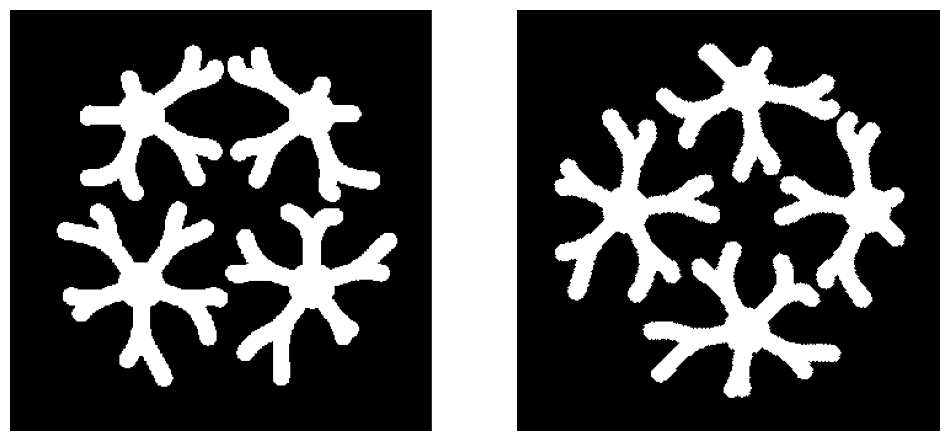

In [26]:


"""Rotation augmentation example, similar as experiments each image rotated per 3.6 degrees i.e 100 rotations per image """
# Define the rotation angle theta in degrees
theta = 45  # Replace with your desired rotation angle
theta_rad = np.deg2rad(theta)

# List all image files in the folder
# image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Process each image file
# for image_file in image_files:
    # Read the image
img = cv2.imread(os.path.join(filepath_sim, filename_sim))

# Find the center of the image (which is also the center of the inscribed circle)
center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

# Radius of the inscribed circle is half the length of the shortest side of the rectangle
radius = min(center_x, center_y)

# Create an output image (initially black or any background color you prefer)
output_img = np.zeros_like(img)

# Perform backward mapping rotation for points within the inscribed circle
for x_prime in range(img.shape[1]):
    for y_prime in range(img.shape[0]):
        # Apply the inverse rotation transformation (backward mapping)
        x = np.cos(theta_rad) * (x_prime - center_x) + np.sin(theta_rad) * (y_prime - center_y) + center_x
        y = -np.sin(theta_rad) * (x_prime - center_x) + np.cos(theta_rad) * (y_prime - center_y) + center_y

        # Check if the source pixel (x, y) is within the inscribed circle's boundaries
        if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
            # Check if it's inside the image
            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                # Sample the pixel from the original image to the output image
                output_img[y_prime, x_prime] = img[int(y), int(x)]

# Convert BGR images to RGB for plotting with matplotlib
output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Display the output image
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
# plt.title('Original image')


plt.subplot(1,2,2)
plt.imshow(output_img_rgb)
plt.axis('off')
# plt.title(f'Rotated Image within Inscribe Circle ')
plt.show()

In [ ]:
"""Describes how the experimental and simulation images were augmented
Note here we just describe how to rotate by a random angle, but in reality we rotate by 100 different angles per image.
Similar to the Seed_DataAugmentation.py file"""

import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# def rotate_image(img, angle, center=None, scale=1.0):
#     (h, w) = img.shape[:2]
#     if center is None:
#         center = (w // 2, h // 2)
#     M = cv2.getRotationMatrix2D(center, angle, scale)
#     rotated = cv2.warpAffine(img, M, (w, h))
#     return rotated

def crop_and_rotate_experimental(img, angle):

    # img = cv2.imread(img)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find edges in the image using Canny edge detection
    edges = cv2.Canny(img_gray, 100, 200)

    # Find circles in the image using HoughCircles method
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)
    
    # print(circles)

    # Assuming the first detected circle is the plate (adjust accordingly)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_center, y_center, radius) in circles:
            # Define a new radius for the mask that is 20 pixels smaller than the detected radius
            new_radius = radius -82
            # print(new_radius)

            # Create a mask where all values are set to zero (black)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

            # Draw a filled white circle on the mask where the new, smaller circle is
            cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

            # Apply the mask to the original image (set pixels outside the new circle to black)
            img_masked = cv2.bitwise_and(img, img, mask=mask)
            
            # Adjust contrast and brightness
            alpha = 1.5  # Contrast control (1.0-3.0)
            beta = 50    # Brightness control (0-100)
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            angle=np.linspace(0,360-3.6,100)
            for i in range(0,len(angle)):
            # Specify the rotation angle theta in degrees
                theta = angle[i]
                theta_rad = np.deg2rad(theta)

                # Create an output image (initially black or any background color you prefer)
                output_img = np.zeros_like(img)

                # Iterate over each pixel in the output image
                for x_prime in range(img.shape[1]):
                    for y_prime in range(img.shape[0]):
                        # Apply the inverse rotation transformation (backward mapping)
                        x = np.cos(theta_rad) * (x_prime - x_center) + np.sin(theta_rad) * (y_prime - y_center) + x_center
                        y = -np.sin(theta_rad) * (x_prime - x_center) + np.cos(theta_rad) * (y_prime - y_center) + y_center

                        # Check if the source pixel (x, y) is within the new circle's boundaries
                        if (x - x_center)**2 + (y - y_center)**2 <= new_radius**2:
                            # Check if it's inside the image
                            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                                # Sample the pixel from the masked image to the output image
                                output_img[y_prime, x_prime] = adjusted_image[int(y), int(x)]

            # # Convert BGR images to RGB for plotting with matplotlib
            # img_masked_rgb = cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB)
            # output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

    #         # Plot the masked original image
    #         plt.figure(figsize=(12, 6))
    #         plt.subplot(1, 2, 1)
    #         plt.imshow(img_masked_rgb)
    #         plt.title('Masked Original Image')

    #         # Plot the image after rotation within the masked circle
    #         plt.subplot(1, 2, 2)
    #         plt.imshow(output_img_rgb)
    #         plt.title('Image after rotation within the masked circle')
    #         plt.show()
                break  # needed since assuming first circle detected by Hough transform is the plate
        
    else:
        print("No circles were found")

    return output_img,adjusted_image
 

def process_simulation_image(img, angle):
    # Find the center of the image (which is also the center of the inscribed circle)

    # img=cv2.imread(img)

    theta = angle # Replace with your desired rotation angle
    theta_rad = np.deg2rad(theta)

    # List all image files in the folder
    # image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image file
    # for image_file in image_files:
        # Read the image
    # img = cv2.imread(os.path.join(folder_path, filepath))

    # Find the center of the image (which is also the center of the inscribed circle)
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

    # Radius of the inscribed circle is half the length of the shortest side of the rectangle
    radius = min(center_x, center_y)

    # Create an output image (initially black or any background color you prefer)
    output_img = np.zeros_like(img)

    # Perform backward mapping rotation for points within the inscribed circle
    for x_prime in range(img.shape[1]):
        for y_prime in range(img.shape[0]):
            # Apply the inverse rotation transformation (backward mapping)
            x = np.cos(theta_rad) * (x_prime - center_x) + np.sin(theta_rad) * (y_prime - center_y) + center_x
            y = -np.sin(theta_rad) * (x_prime - center_x) + np.cos(theta_rad) * (y_prime - center_y) + center_y

            # Check if the source pixel (x, y) is within the inscribed circle's boundaries
            if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
                # Check if it's inside the image
                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                    # Sample the pixel from the original image to the output image
                    output_img[y_prime, x_prime] = img[int(y), int(x)]
    
    return output_img

# Define the folders
experimental_folder = '/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed'
simulation_folder = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'
new_experimental_folder = '/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed_aug4'
new_simulation_folder = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL_aug4'
non_rotated_experimental_folder='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed_cropped_v4'

# Ensure the new folders exist
os.makedirs(new_experimental_folder, exist_ok=True)
os.makedirs(new_simulation_folder, exist_ok=True)
os.makedirs(non_rotated_experimental_folder,exist_ok=True)

# Get the file lists
experimental_files = sorted(os.listdir(experimental_folder))
simulation_files = sorted(os.listdir(simulation_folder))

# Verify that each filename matches in both folders
matched_files = set(experimental_files).intersection(simulation_files)



# Process each pair of images
for filename in sorted(matched_files):
    
    print(filename)
    # Select a random angle between 0 and 360 degrees 
    angle = random.randint(0, 359)

    # Read the experimental image
    exp_img = cv2.imread(os.path.join(experimental_folder, filename))
    # Crop and rotate the experimental image
    rotated_exp_img, cropped_exp_img = crop_and_rotate_experimental(exp_img, angle)

    # Read the simulation image
    sim_img = cv2.imread(os.path.join(simulation_folder, filename))
    # Process and rotate the simulation image
    rotated_sim_img = process_simulation_image(sim_img, angle)

    # Save the new images in the new folders with the angle in the filename
    new_exp_filename = f"{os.path.splitext(filename)[0]}_rot{angle}{os.path.splitext(filename)[1]}"
    new_sim_filename = f"{os.path.splitext(filename)[0]}_rot{angle}{os.path.splitext(filename)[1]}"

    cv2.imwrite(os.path.join(new_experimental_folder, new_exp_filename), rotated_exp_img)
    cv2.imwrite(os.path.join(new_simulation_folder, new_sim_filename), rotated_sim_img)
    cv2.imwrite(os.path.join(non_rotated_experimental_folder,filename),cropped_exp_img)

    # print("Processed and wrote first file")
    # break

print("Processing completed.")


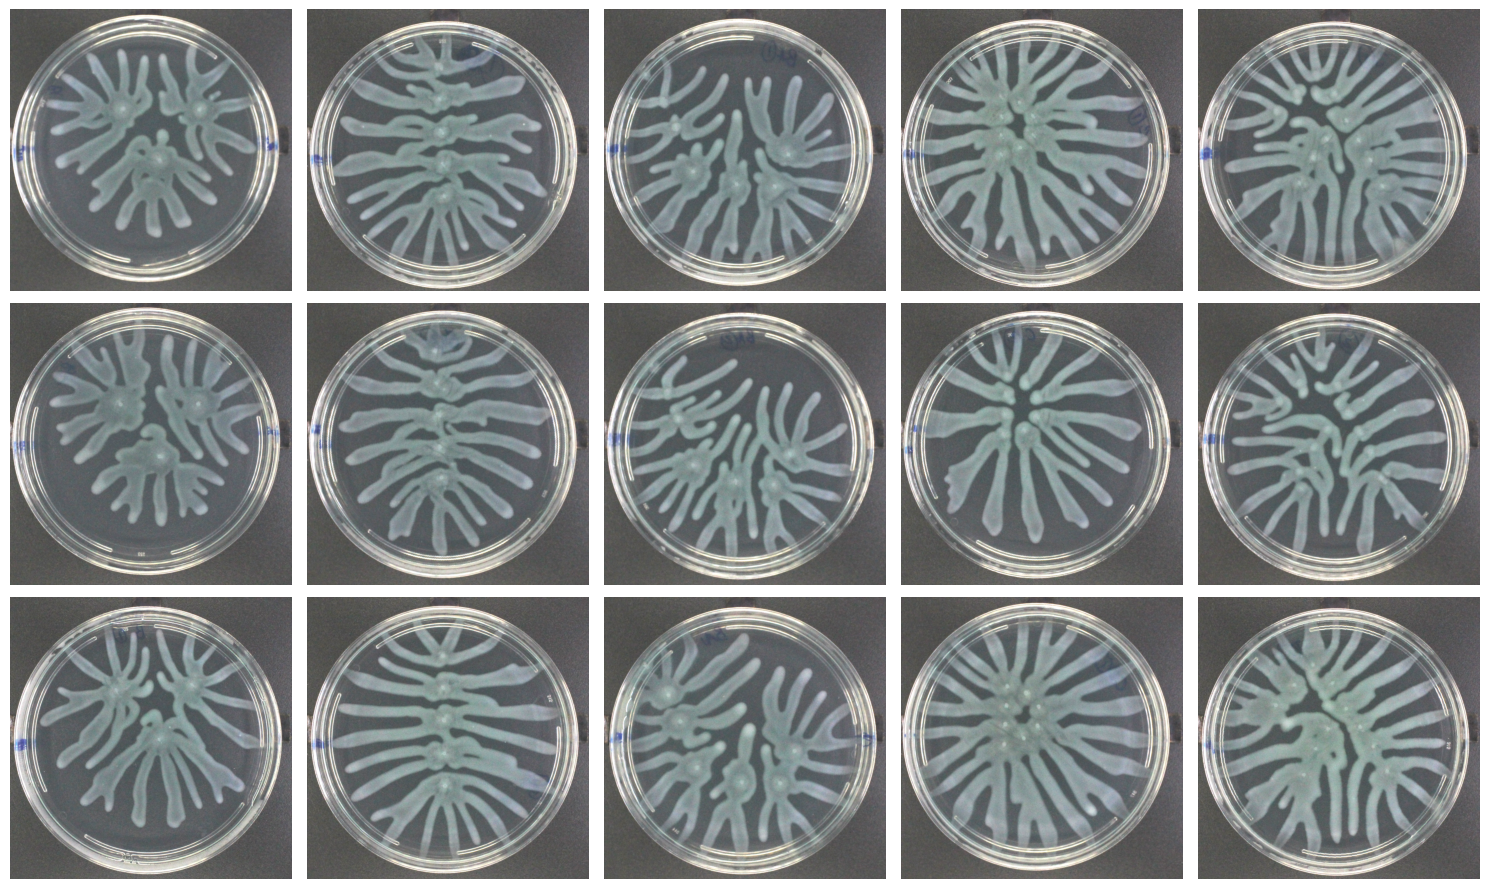

In [ ]:

"""Just visualization of the original experimental images with replicates, enhancing contrast and brightness but no cropping"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Sample indices (hardcoded)
selected_indices = [19,27,15,22, 28]  # You can adjust these based on your selected samples
replicates = [1, 2, 3]

# Path to the folder containing the images
image_folder = "/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed"

# Image processing function to adjust contrast and brightness
def adjust_contrast_brightness(img, alpha=1.5, beta=50):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)


# Create a 3x5 plot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

# Loop over the samples and replicates
for col, sample_idx in enumerate(selected_indices):
    for row, replicate in enumerate(replicates):
        # Construct the file name
        image_file = f"Fixed_{sample_idx}_{replicate}.TIF"
        image_path = os.path.join(image_folder, image_file)


        # Read the image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Error loading {image_file}")
            continue
        
        # Apply image processing (contrast and brightness adjustment)
        adjusted_image = adjust_contrast_brightness(img)

        # Display the processed image in the grid
        axs[row, col].imshow(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')  # Hide the axes
        # axs[row, col].set_title(f"Sample {sample_idx}, Rep {replicate}")

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_2529339/2427955367.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


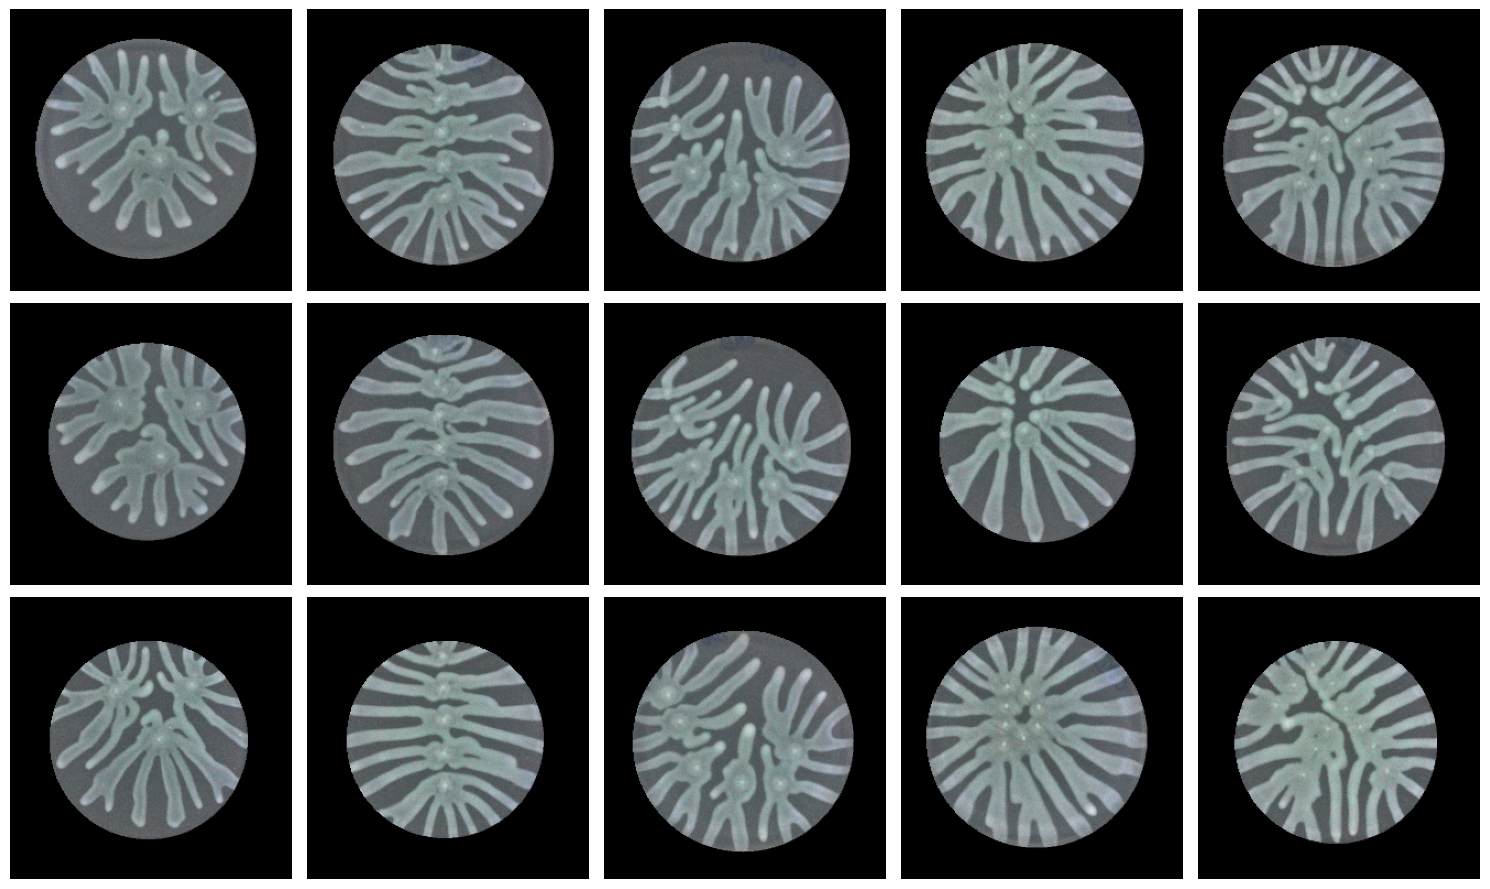

In [ ]:
"""Visualization of the cropped experimental images with replicates, enhancing contrast and brightness,
currently the grid used in the AI vs Real Game on Huggingface Hub to give an example of the real experimental images"""


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Sample indices (hardcoded)
selected_indices = [19,27,15,22, 28]  # You can adjust these based on your selected samples
replicates = [1, 2, 3]

# Path to the folder containing the images
image_folder = "/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed"

# Image processing function to adjust contrast and brightness
def adjust_contrast_brightness(img, alpha=1.5, beta=50):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def preprocess_experimental_initialstage(img_path, img_length=256,img_width=256):

    """
    Preprocess single image in color from rw experimental data.

    Accepts: Input image path, raw experimental data 

    Returns: PIL.Image: Color and Cropped image of Experimental data. Cropped exterior is a black masked circle. 

    """

    img = cv2.imread(img_path)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find edges in the image using Canny edge detection
    edges = cv2.Canny(img_gray, 100, 200)

    # Find circles in the image using HoughCircles method
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)

    # print(circles)

    # Assuming the first detected circle is the plate (adjust accordingly)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_center, y_center, radius) in circles:
            # Define a new radius for the mask that is 20 pixels smaller than the detected radius
            new_radius = radius -82
            # print(new_radius)

            # Create a mask where all values are set to zero (black)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

            # Draw a filled white circle on the mask where the new, smaller circle is
            cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

            # Apply the mask to the original image (set pixels outside the new circle to black)
            img_masked = cv2.bitwise_and(img, img, mask=mask)


            # Adjust contrast and brightness
            alpha = 1.5  # Contrast control (1.0-3.0)
            beta = 50    # Brightness control (0-100)
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            

            # Convert BGR images to RGB for plotting with matplotlib
            img_masked_rgb = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB)
            # output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

            # output_img_grayscale=cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)
            # blur = cv2.GaussianBlur(output_img_grayscale,(5,5),0)   
            # ret3,th3 = cv2.threshold(blur,110,255,cv2.THRESH_BINARY)
            # ########################
            # img_array_i=th3


               # resize both the adjusted image and the mask
            img_resized = cv2.resize(img_masked_rgb, (img_length, img_width))
            mask_resized = cv2.resize(mask,(img_length, img_width),interpolation=cv2.INTER_NEAREST)

            # re-mask the resized image to force a black border outside the circle
            img_masked_resized = cv2.bitwise_and(img_resized,img_resized,mask=mask_resized)
            return img_masked_resized
    else:
        print("No circles were found")
        return None



# Create a 3x5 plot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9),layout='constrained')

# Loop over the samples and replicates
for col, sample_idx in enumerate(selected_indices):
    for row, replicate in enumerate(replicates):
        # Construct the file name
        image_file = f"Fixed_{sample_idx}_{replicate}.TIF"
        image_path = os.path.join(image_folder, image_file)

        # Process the image
        img= preprocess_experimental_initialstage(image_path, img_length=256, img_width=256)
    

        # Display the processed image in the grid
        axs[row, col].imshow(img)
        axs[row, col].axis('off')  # Hide the axes
        # axs[row, col].set_title(f"Sample {sample_idx}, Rep {replicate}")

# Show the plot
plt.tight_layout()
plt.show()